# 人脸生成（Face Generation）
在该项目中，你将使用生成式对抗网络（Generative Adversarial Nets）来生成新的人脸图像。
### 获取数据
该项目将使用以下数据集：
- MNIST
- CelebA

由于 CelebA 数据集比较复杂，而且这是你第一次使用 GANs。我们想让你先在 MNIST 数据集上测试你的 GANs 模型，以让你更快的评估所建立模型的性能。

如果你在使用 [FloydHub](https://www.floydhub.com/), 请将 `data_dir` 设置为 "/input" 并使用 [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [4]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Extracting celeba...


## 探索数据（Explore the Data）
### MNIST
[MNIST](http://yann.lecun.com/exdb/mnist/) 是一个手写数字的图像数据集。你可以更改 `show_n_images` 探索此数据集。

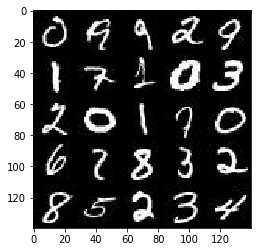

In [5]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
[CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) 是一个包含 20 多万张名人图片及相关图片说明的数据集。你将用此数据集生成人脸，不会用不到相关说明。你可以更改 `show_n_images` 探索此数据集。

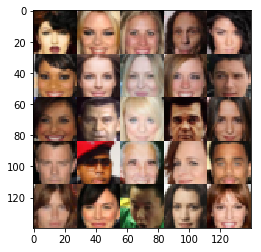

In [6]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## 预处理数据（Preprocess the Data）
由于该项目的重点是建立 GANs 模型，我们将为你预处理数据。

经过数据预处理，MNIST 和 CelebA 数据集的值在 28×28 维度图像的 [-0.5, 0.5] 范围内。CelebA 数据集中的图像裁剪了非脸部的图像部分，然后调整到 28x28 维度。

MNIST 数据集中的图像是单[通道](https://en.wikipedia.org/wiki/Channel_(digital_image%29)的黑白图像，CelebA 数据集中的图像是 [三通道的 RGB 彩色图像](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images)。

## 建立神经网络（Build the Neural Network）
你将通过部署以下函数来建立 GANs 的主要组成部分:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### 检查 TensorFlow 版本并获取 GPU 型号
检查你是否使用正确的 TensorFlow 版本，并获取 GPU 型号

In [7]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### 输入（Input）
部署 `model_inputs` 函数以创建用于神经网络的 [占位符 (TF Placeholders)](https://www.tensorflow.org/versions/r0.11/api_docs/python/io_ops/placeholders)。请创建以下占位符：
- 输入图像占位符: 使用 `image_width`，`image_height` 和 `image_channels` 设置为 rank 4。
- 输入 Z 占位符: 设置为 rank 2，并命名为 `z_dim`。
- 学习速率占位符: 设置为 rank 0。

返回占位符元组的形状为 (tensor of real input images, tensor of z data, learning rate)。


In [8]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    input_images = tf.placeholder(tf.float32, (None,image_width, image_height, image_channels))
    input_z = tf.placeholder(tf.float32, (None, z_dim), name="z_dim")
    learning_rate = tf.placeholder(tf.float32)

    return (input_images, input_z, learning_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### 辨别器（Discriminator）
部署 `discriminator` 函数创建辨别器神经网络以辨别 `images`。该函数应能够重复使用神经网络中的各种变量。 在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "discriminator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回形如 (tensor output of the discriminator, tensor logits of the discriminator) 的元组。

In [9]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    alpha = 0.01
    with tf.variable_scope('discriminator', reuse=reuse):
        # 28*28
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 14x14x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 7x7x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### 生成器（Generator）
部署 `generator` 函数以使用 `z` 生成图像。该函数应能够重复使用神经网络中的各种变量。
在 [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) 中使用 "generator" 的变量空间名来重复使用该函数中的变量。 

该函数应返回所生成的 28 x 28 x `out_channel_dim` 维度图像。

In [10]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    alpha = 0.01
    with tf.variable_scope('generator',reuse=not is_train):
        x1 = tf.layers.dense(z, 7*7*512)
        
        x1 = tf.reshape(x1, (-1, 7, 7, 512))
        x1 = tf.layers.batch_normalization(x1, training=True)
        x1 = tf.maximum(alpha * x1, x1)
        # 7x7x512
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=True)
        x2 = tf.maximum(alpha * x2, x2)
        # 14x14x256
        
        logits = tf.layers.conv2d_transpose(x2, out_channel_dim, 5, strides=2, padding='same')
        # 28x28x3 
        
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### 损失函数（Loss）
部署 `model_loss` 函数训练并计算 GANs 的损失。该函数应返回形如 (discriminator loss, generator loss) 的元组。

使用你已实现的函数：
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [11]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, out_channel_dim)
    d_model_real, d_logits_real = discriminator(input_real)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### 优化（Optimization）
部署 `model_opt` 函数实现对 GANs 的优化。使用 [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) 获取可训练的所有变量。通过变量空间名 `discriminator` 和 `generator` 来过滤变量。该函数应返回形如 (discriminator training operation, generator training operation) 的元组。

In [12]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## 训练神经网络（Neural Network Training）
### 输出显示
使用该函数可以显示生成器 (Generator) 在训练过程中的当前输出，这会帮你评估 GANs 模型的训练程度。

In [13]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### 训练
部署 `train` 函数以建立并训练 GANs 模型。记得使用以下你已完成的函数：
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

使用 `show_generator_output` 函数显示 `generator` 在训练过程中的输出。

**注意**：在每个批次 (batch) 中运行 `show_generator_output` 函数会显著增加训练时间与该 notebook 的体积。推荐每 100 批次输出一次 `generator` 的输出。 

In [14]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    input_real, input_z,_ = model_inputs(data_shape[1],data_shape[2],data_shape[3], z_dim)
    out_channel_dim = 3 if data_image_mode == 'RGB' else 1
    d_loss, g_loss = model_loss(input_real, input_z,out_channel_dim)
        
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    steps = 0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                _ = sess.run(g_opt, feed_dict={input_real: batch_images, input_z: batch_z})
                
                if steps % 100 == 0:
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})
                    print("Discriminator Loss: {:.4f}...".format(train_loss_d),"Generator Loss: {:.4f}".format(train_loss_g))
                    show_generator_output(sess, 25,input_z,out_channel_dim,data_image_mode)

### MNIST
在 MNIST 上测试你的 GANs 模型。经过 2 次迭代，GANs 应该能够生成类似手写数字的图像。确保生成器 (generator) 低于辨别器 (discriminator) 的损失，或接近 0。

Discriminator Loss: 0.9863... Generator Loss: 3.1916


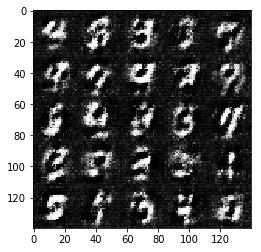

Discriminator Loss: 0.3229... Generator Loss: 2.0742


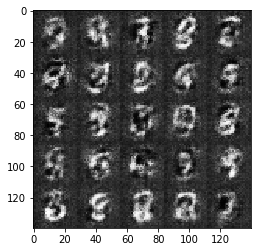

Discriminator Loss: 0.1302... Generator Loss: 3.6936


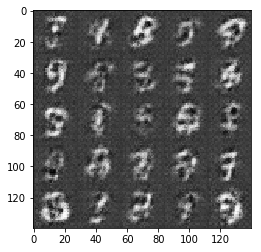

Discriminator Loss: 0.0791... Generator Loss: 3.9545


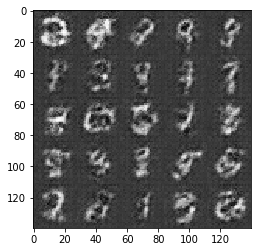

Discriminator Loss: 0.2415... Generator Loss: 2.0444


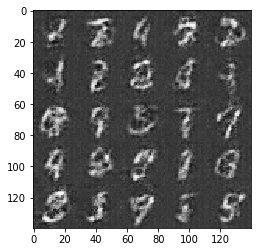

Discriminator Loss: 0.1008... Generator Loss: 3.2097


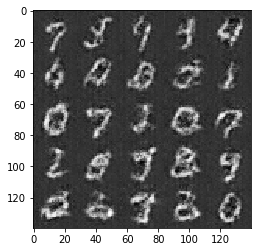

Discriminator Loss: 0.3139... Generator Loss: 1.7644


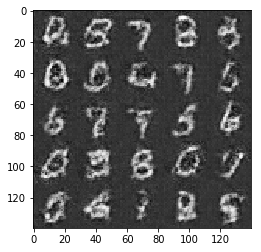

Discriminator Loss: 0.2084... Generator Loss: 2.1149


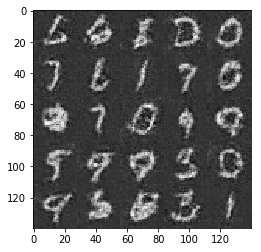

Discriminator Loss: 0.0510... Generator Loss: 3.5824


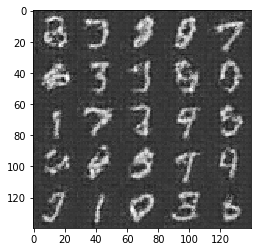

In [19]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
在 CelebA 上运行你的 GANs 模型。在一般的GPU上运行每次迭代大约需要 20 分钟。你可以运行整个迭代，或者当 GANs 开始产生真实人脸图像时停止它。

Discriminator Loss: 0.5313... Generator Loss: 1.4080


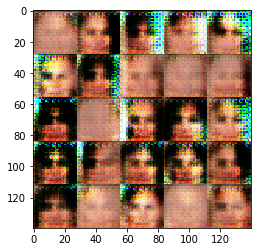

Discriminator Loss: 0.0082... Generator Loss: 5.6272


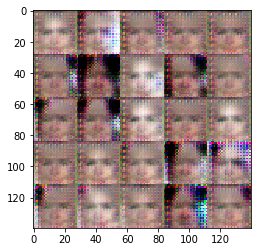

Discriminator Loss: 0.0402... Generator Loss: 4.7909


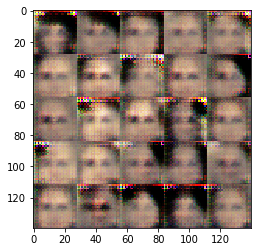

Discriminator Loss: 0.6033... Generator Loss: 1.4890


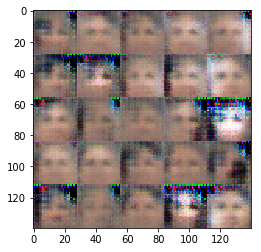

Discriminator Loss: 0.1381... Generator Loss: 3.7896


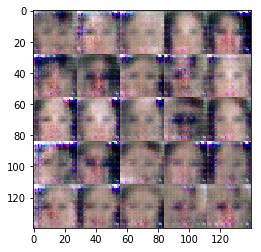

Discriminator Loss: 0.0074... Generator Loss: 5.3644


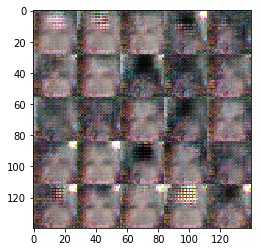

Discriminator Loss: 0.0451... Generator Loss: 3.7216


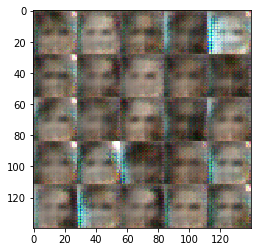

Discriminator Loss: 1.1411... Generator Loss: 0.7809


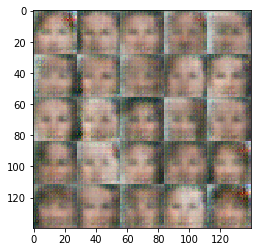

Discriminator Loss: 1.1930... Generator Loss: 0.6529


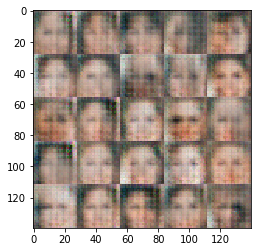

Discriminator Loss: 1.3545... Generator Loss: 0.6800


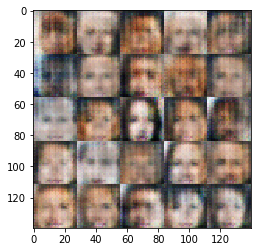

Discriminator Loss: 1.5003... Generator Loss: 1.4801


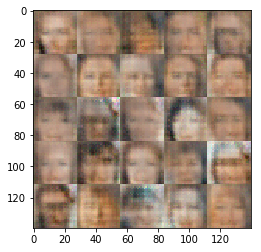

Discriminator Loss: 1.2191... Generator Loss: 0.7504


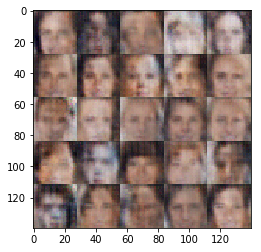

Discriminator Loss: 1.1289... Generator Loss: 0.8256


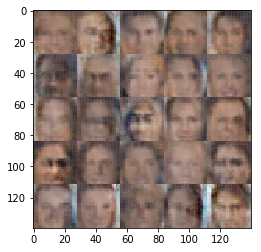

Discriminator Loss: 1.4482... Generator Loss: 1.0129


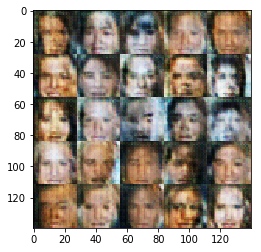

Discriminator Loss: 1.4559... Generator Loss: 0.5540


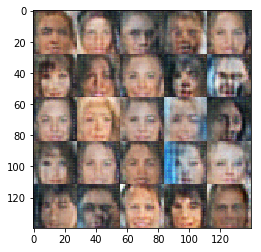

In [20]:
batch_size = 128
z_dim = 100
learning_rate = 0.001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### 提交项目
提交本项目前，确保运行所有 cells 后保存该文件。

保存该文件为 "dlnd_face_generation.ipynb"， 并另存为 HTML 格式 "File" -> "Download as"。提交项目时请附带 "helper.py" 和 "problem_unittests.py" 文件。